# TP1: Metodología Box-Jenkins y Suavizado Exponencial ETS

# 1. Configuración inicial y carga de datos

### 1.1 Instalación y carga de librerías

In [140]:
# Instalar paquetes si no están disponibles
# if(!require(readxl)) install.packages("readxl")
# if(!require(forecast)) install.packages("forecast")
# if(!require(tseries)) install.packages("tseries")
# if(!require(ggplot2)) install.packages("ggplot2")
# if(!require(dplyr)) install.packages("dplyr") # Incluido en tidyverse
# if(!require(zoo)) install.packages("zoo")
# if(!require(lubridate)) install.packages("lubridate")
# if(!require(officer)) install.packages("officer")
# if(!require(flextable)) install.packages("flextable")
# if(!require(tidyverse)) install.packages("tidyverse")

# Cargar librerías necesarias
library(readxl)
library(forecast)
library(tseries)
library(zoo)
library(lubridate)
library(officer)
library(flextable)
library(tidyverse) # Incluye ggplot2, dplyr, etc.


# Definir ruta del proyecto (Asegúrate que esta ruta sea correcta para tu entorno)
project_path <- "C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1" # Mantén tu ruta o ajústala si es necesario

# 2.1) Cargar función de diagnóstico de residuos
# Asegúrate que 'corr_res.R' esté en la ruta correcta o en 'project_path'
source(file.path(project_path, "corr_res.R"))
# Cargar funciones auxiliares (incluida save_corr_table)
# Cargar funciones auxiliares (incluida save_corr_table)
source(file.path(project_path, "save_utils.R"))
source(file.path(project_path, "plot_forecast_comparison.R"))
source(file.path(project_path, "eval_pron.R"))

# Configurar opciones
options(scipen = 999) # Evitar notación científica
par(bg = "white") # Fondo blanco para gráficos base

### 1.2 Lectura de datos

In [141]:
# Leer datos de Argentina (skip=1 para eliminar sólo el título)
datos_arg <- read_excel(
  file.path(project_path, "Datos Argentina.xlsx"),
  skip      = 1,
  col_names = c("Periodo", "EMAE", "IPC", "M2N", "M2R", "TASA")
)

# Leer datos de Chile (skip=3 para saltar título, línea en blanco y cabecera)
datos_chi <- read_excel(
  file.path(project_path, "Datos Chile.xlsx"),
  skip      = 3,
  col_names = c("Periodo", "IMACEC", "M2N", "IPC", "M2R", "TASA")
)

# Mostrar primeras filas para verificar
head(datos_arg, 5)
head(datos_chi, 5)


Periodo,EMAE,IPC,M2N,M2R,TASA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004M01,98.44894,77.33982,66006023,66006023,4.57
2004M02,98.17701,77.18623,67545780,67680182,4.03
2004M03,97.80754,77.32858,68027349,68037235,3.69
2004M04,95.04287,77.62270,70499728,70242804,3.48
2004M05,96.89273,77.75169,72987490,72600858,3.54


Periodo,IMACEC,M2N,IPC,M2R,TASA
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-01,56.95508,22880.17,46.12519,22880.17,6.107525
2004-02-01,54.85665,22853.76,46.12926,22851.74,6.407674
2004-03-01,61.86300,23231.16,46.32336,23131.78,6.943765
2004-04-01,60.63709,23852.51,46.49362,23663.49,6.637812
2004-05-01,60.08506,23705.82,46.73653,23395.73,6.957272


# 2. Preparación de series temporales



### 2.1 Creación de series temporales y diferencias logarítmicas

In [142]:
# Crear columna de Fecha para Argentina
datos_arg$Fecha <- as.Date(as.yearmon(gsub("M", "-", datos_arg$Periodo), "%Y-%m"))

# Crear columna de Fecha para Chile (corregido para formato YYYYMM)
datos_chi$Fecha <- as.Date(as.yearmon(gsub("M", "-", datos_chi$Periodo), "%Y-%m"))

# Crear objetos ts (time series) a partir de enero-2004
ts_emae     <- ts(datos_arg$EMAE, start = c(2004, 1), frequency = 12)
ts_ipc_arg  <- ts(datos_arg$IPC,  start = c(2004, 1), frequency = 12)
ts_m2_arg   <- ts(datos_arg$M2N,  start = c(2004, 1), frequency = 12)
ts_tasa_arg <- ts(datos_arg$TASA, start = c(2004, 1), frequency = 12)

ts_imacec   <- ts(datos_chi$IMACEC, start = c(2004, 1), frequency = 12)
ts_ipc_chi  <- ts(datos_chi$IPC,    start = c(2004, 1), frequency = 12)
ts_m2_chi   <- ts(datos_chi$M2N,    start = c(2004, 1), frequency = 12)
ts_tasa_chi <- ts(datos_chi$TASA,   start = c(2004, 1), frequency = 12)

# (Opcional) Verificar las fechas creadas
# head(datos_arg$Fecha)
# head(datos_chi$Fecha)

In [143]:
# 2.1 Creación de series y diferencias logarítmicas

# Función para calcular la diferencia logarítmica
# (aproxima la tasa de crecimiento)
calcular_diff_log <- function(x) {
  diff(log(x))
}

# Lista con las series temporales originales en niveles
series <- list(
  emae     = ts_emae,
  ipc_arg  = ts_ipc_arg,
  m2_arg   = ts_m2_arg,
  tasa_arg = ts_tasa_arg,
  imacec   = ts_imacec,
  ipc_chi  = ts_ipc_chi,
  m2_chi   = ts_m2_chi,
  tasa_chi = ts_tasa_chi
)

# Bucle para crear las series con diferencias logarítmicas (dl_...)
# Nota: Se usa assign() para crear dinámicamente los nombres de las variables.
# Se ajusta la fecha de inicio porque diff() reduce la longitud en 1.
for(i in names(series)) {
  original_series <- series[[i]]
  transformed_series <- calcular_diff_log(original_series)
  # Convertir de nuevo a ts especificando inicio y frecuencia
  dl_series_ts <- ts(
    transformed_series,
    start     = time(original_series)[2], # El inicio es el segundo período del original
    # O alternativamente, si prefieres la notación año/mes: start(original_series)[1:2] + c(0, 1)
    frequency = frequency(original_series)
  )
  assign(paste0("dl_", i), dl_series_ts) # Crea ej: dl_emae, dl_ipc_arg, etc.
}

# Lista con los nombres de las series diferenciadas que se usarán para entrenamiento
train_series_names <- names(series) # Usamos los mismos nombres base

# Bucle para crear las ventanas de entrenamiento (..._train)
# Período de entrenamiento: hasta diciembre 2022
for (i in train_series_names) {
  # Accedemos a la variable dl_ creada en el bucle anterior usando get()
  full_dl_series <- get(paste0("dl_", i))
  # Creamos la ventana de entrenamiento
  train_window <- window(full_dl_series, end = c(2022, 12))
  # Asignamos a la nueva variable _train
  assign(paste0("dl_", i, "_train"), train_window) # Crea ej: dl_emae_train, etc.
}

# (Opcional) Verificar una de las series creadas y su versión de entrenamiento
# print(head(dl_emae))
# print(head(dl_emae_train))
# print(frequency(dl_emae))

# 3. Estimacion de modelos

## Argentina

### 3.1 Estimacion EMAE - Arg

In [144]:
# 3.0 Estimación de modelos
## Argentina:
### 3.1 Estimación del EMAE para Argentina

# Definir órdenes del modelo ARIMA estacional
p_emae <- 4; d_emae <- 0; q_emae <- 0
P_emae <- 0; D_emae <- 1; Q_emae <- 1

# Estimar el modelo ARIMA
model_emae_arg <- forecast::Arima(
  dl_emae_train,
  order = c(p_emae, d_emae, q_emae),
  seasonal = list(order = c(P_emae, D_emae, Q_emae), period = 12),
  method = "ML"
)

# Calcular diagnóstico de residuos
corr1 <- corr_res(
  model_emae_arg,
  lags = 26,
  p_q = p_emae + q_emae + P_emae + Q_emae
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr1)

# Guardar la tabla de diagnóstico en un archivo .docx usando la nueva función
# Los archivos se guardarán en la subcarpeta 'output_tables' dentro de 'project_path'
save_corr_table(corr_result = corr1,
                filename_base = "emae_arg", # Nombre base del archivo
                output_dir = project_path)  # Directorio del proyecto

# Mostrar resumen del modelo ajustado
summary(model_emae_arg)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.0346"      "NA"    
 [2,] "2"  "0.061"       "NA"    
 [3,] "3"  "0.1154"      "NA"    
 [4,] "4"  "0.1463"      "NA"    
 [5,] "5"  "0.3813"      "NA"    
 [6,] "6"  "1.2043"      "0.2725"
 [7,] "7"  "2.1663"      "0.3385"
 [8,] "8"  "2.2652"      "0.5192"
 [9,] "9"  "5.9686"      "0.2015"
[10,] "10" "6.6301"      "0.2496"
[11,] "11" "9.0891"      "0.1686"
[12,] "12" "9.485"       "0.2197"
[13,] "13" "9.919"       "0.2708"
[14,] "14" "10.0237"     "0.3486"
[15,] "15" "10.0605"     "0.4352"
[16,] "16" "10.2931"     "0.5042"
[17,] "17" "10.4991"     "0.5723"
[18,] "18" "10.5606"     "0.6476"
[19,] "19" "10.638"      "0.7142"
[20,] "20" "14.2656"     "0.5055"
[21,] "21" "15.0308"     "0.5224"
[22,] "22" "15.052"      "0.5917"
[23,] "23" "17.1968"     "0.5096"
[24,] "24" "20.1316"     "0.3867"
[25,] "25" "21.3206"     "0.3785"
[26,] "26" "21.3396"     "0.4384"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/emae_arg_corr.docx



Series: dl_emae_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4     sma1
      0.1087  -0.1193  0.0291  0.0151  -0.9549
s.e.  0.0681   0.0683  0.0684  0.0682   0.1140

sigma^2 = 0.0003779:  log likelihood = 531.23
AIC=-1050.45   AICc=-1050.05   BIC=-1030.23

Training set error measures:
                       ME       RMSE        MAE      MPE    MAPE     MASE
Training set -0.001823165 0.01869647 0.01109177 97.38346 245.977 0.651687
                    ACF1
Training set -0.01225977

### 3.2 Estimacion IPC - Arg

In [145]:
### 3.2 IPC Argentina

# Definir órdenes del modelo ARIMA estacional
p_ipc <- 3; d_ipc <- 0; q_ipc <- 0
P_ipc <- 0; D_ipc <- 1; Q_ipc <- 1

# Estimar el modelo ARIMA
model_ipc_arg <- forecast::Arima( # Usar namespace explícito
  dl_ipc_arg_train,
  order = c(p_ipc, d_ipc, q_ipc),
  seasonal = list(order = c(P_ipc, D_ipc, Q_ipc), period = 12),
  method = "ML"
)

# Calcular diagnóstico de residuos
corr2 <- corr_res(
  model_ipc_arg,
  lags = 26,
  p_q = p_ipc + q_ipc + P_ipc + Q_ipc # Grados de libertad
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr2)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr2,
                filename_base = "ipc_arg", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado
summary(model_ipc_arg)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.2105"      "NA"    
 [2,] "2"  "0.4043"      "NA"    
 [3,] "3"  "0.5278"      "NA"    
 [4,] "4"  "0.8899"      "NA"    
 [5,] "5"  "3.8074"      "0.051" 
 [6,] "6"  "3.8653"      "0.1448"
 [7,] "7"  "4.0211"      "0.2592"
 [8,] "8"  "6.6917"      "0.1531"
 [9,] "9"  "7.6487"      "0.1767"
[10,] "10" "8.5062"      "0.2033"
[11,] "11" "9.0164"      "0.2515"
[12,] "12" "9.0623"      "0.3371"
[13,] "13" "9.1018"      "0.4279"
[14,] "14" "9.6927"      "0.4679"
[15,] "15" "10.5029"     "0.4858"
[16,] "16" "12.0139"     "0.4446"
[17,] "17" "12.5574"     "0.4826"
[18,] "18" "14.5608"     "0.4088"
[19,] "19" "14.5612"     "0.4835"
[20,] "20" "14.5633"     "0.5568"
[21,] "21" "15.5747"     "0.5542"
[22,] "22" "16.6855"     "0.5448"
[23,] "23" "17.3014"     "0.5695"
[24,] "24" "25.0464"     "0.1997"
[25,] "25" "25.3031"     "0.2343"
[26,] "26" "25.3558"     "0.2804"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/ipc_arg_corr.docx



Series: dl_ipc_arg_train 
ARIMA(3,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     sma1
      0.3718  0.2894  0.1128  -0.8476
s.e.  0.0683  0.0717  0.0693   0.0610

sigma^2 = 0.0001413:  log likelihood = 642.08
AIC=-1274.17   AICc=-1273.88   BIC=-1257.32

Training set error measures:
                     ME       RMSE         MAE       MPE     MAPE      MASE
Training set 0.00182997 0.01145982 0.008247476 -70.32671 114.9075 0.6116113
                    ACF1
Training set -0.03025047

### 3.3 Estimacion Agregado Monetario M2 - Arg

In [146]:
### 3.3 Estimación Agregado Monetario M2, Argentina

# Definir órdenes del modelo ARIMA estacional
p_m2 <- 1; d_m2 <- 0; q_m2 <- 4 # Órdenes no estacionales
P_m2 <- 0; D_m2 <- 1; Q_m2 <- 1 # Órdenes estacionales

# Estimar el modelo ARIMA
model_m2_arg <- forecast::Arima(
  dl_m2_arg_train,
  order    = c(p_m2, d_m2, q_m2),
  seasonal = list(order = c(P_m2, D_m2, Q_m2), period = 12),
  method   = "ML"
)

# Calcular diagnóstico de residuos
corr3 <- corr_res(
  model_m2_arg,
  lags = 26,
  p_q  = p_m2 + q_m2 + P_m2 + Q_m2 # Grados de libertad (1+4+0+1 = 6)
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr3)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr3,
                filename_base = "m2_arg", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado
summary(model_m2_arg)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.0026"      "NA"    
 [2,] "2"  "0.0104"      "NA"    
 [3,] "3"  "0.0592"      "NA"    
 [4,] "4"  "0.0604"      "NA"    
 [5,] "5"  "0.1509"      "NA"    
 [6,] "6"  "0.3754"      "NA"    
 [7,] "7"  "1.1366"      "0.2864"
 [8,] "8"  "1.2256"      "0.5418"
 [9,] "9"  "1.4537"      "0.693" 
[10,] "10" "4.5406"      "0.3378"
[11,] "11" "4.5867"      "0.4684"
[12,] "12" "5.3111"      "0.5046"
[13,] "13" "5.3538"      "0.6169"
[14,] "14" "6.4138"      "0.601" 
[15,] "15" "6.697"       "0.6686"
[16,] "16" "13.925"      "0.1764"
[17,] "17" "14.2938"     "0.2172"
[18,] "18" "14.6027"     "0.2639"
[19,] "19" "16.8855"     "0.2046"
[20,] "20" "18.1856"     "0.1985"
[21,] "21" "20.3752"     "0.158" 
[22,] "22" "20.4368"     "0.2012"
[23,] "23" "20.9888"     "0.2268"
[24,] "24" "21.0212"     "0.2783"
[25,] "25" "21.0229"     "0.3355"
[26,] "26" "22.0234"     "0.3392"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/m2_arg_corr.docx



Series: dl_m2_arg_train 
ARIMA(1,0,4)(0,1,1)[12] 

Coefficients:
          ar1     ma1     ma2     ma3     ma4     sma1
      -0.6257  0.5542  0.0122  0.2789  0.3190  -0.7056
s.e.   0.2159  0.2109  0.0775  0.0714  0.0665   0.0814

sigma^2 = 0.0007509:  log likelihood = 466.94
AIC=-919.89   AICc=-919.35   BIC=-896.29

Training set error measures:
                      ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.002100576 0.02629295 0.01895284 12.85338 117.0499 0.7867427
                     ACF1
Training set -0.003363185

### 3.4 Estimacion Tasa de interes - Arg

In [147]:
### 3.4 Estimación de Tasas de interés, Argentina

# Especificar órdenes del modelo ARIMA estacional
p_tasa <- 4; d_tasa <- 0; q_tasa <- 0
P_tasa <- 0; D_tasa <- 1; Q_tasa <- 1

# Estimar el modelo ARIMA
model_tasa_arg <- forecast::Arima( # Usar namespace explícito
  dl_tasa_arg_train,
  order = c(p_tasa, d_tasa, q_tasa),
  seasonal = list(order = c(P_tasa, D_tasa, Q_tasa), period = 12),
  method = "ML"
)

# Calcular diagnóstico de residuos
corr4 <- corr_res(
  model_tasa_arg,
  lags = 26,
  p_q = p_tasa + q_tasa + P_tasa + Q_tasa # Grados de libertad
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr4)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr4,
                filename_base = "tasa_arg", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado
summary(model_tasa_arg)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.0067"      "NA"    
 [2,] "2"  "0.0067"      "NA"    
 [3,] "3"  "0.0852"      "NA"    
 [4,] "4"  "0.5813"      "NA"    
 [5,] "5"  "1.5438"      "NA"    
 [6,] "6"  "1.6629"      "0.1972"
 [7,] "7"  "4.3407"      "0.1141"
 [8,] "8"  "4.727"       "0.1929"
 [9,] "9"  "4.8562"      "0.3024"
[10,] "10" "5.2552"      "0.3855"
[11,] "11" "5.8239"      "0.4432"
[12,] "12" "6.9065"      "0.4387"
[13,] "13" "7.0852"      "0.5275"
[14,] "14" "7.6963"      "0.565" 
[15,] "15" "9.1374"      "0.5191"
[16,] "16" "9.2831"      "0.5958"
[17,] "17" "9.3288"      "0.6746"
[18,] "18" "16.8167"     "0.2078"
[19,] "19" "16.9706"     "0.2578"
[20,] "20" "18.2691"     "0.2488"
[21,] "21" "19.195"      "0.2587"
[22,] "22" "19.4157"     "0.3052"
[23,] "23" "23.8456"     "0.1602"
[24,] "24" "24.6894"     "0.171" 
[25,] "25" "24.9092"     "0.2049"
[26,] "26" "25.0228"     "0.2462"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/tasa_arg_corr.docx



Series: dl_tasa_arg_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1      ar2     ar3     ar4    sma1
      0.5637  -0.2021  0.0070  0.0732  -1.000
s.e.  0.0681   0.0781  0.0781  0.0682   0.094

sigma^2 = 0.002731:  log likelihood = 314.22
AIC=-616.43   AICc=-616.03   BIC=-596.21

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE         ACF1
Training set 0.001583406 0.05026569 0.03361232 NaN  Inf 0.5223795 -0.005378132

## Chile

### 3.5 Estimacion IMACEC - Chile

In [148]:
## Chile:
### 3.5 Estimación IMACEC-Chile

# Definir órdenes del modelo ARIMA estacional
p_imacec <- 4; d_imacec <- 0; q_imacec <- 2
P_imacec <- 0; D_imacec <- 1; Q_imacec <- 1

# Estimar el modelo ARIMA
model_imacec_chi <- forecast::Arima( # Usar namespace explícito
  y = dl_imacec_train,
  order = c(p_imacec, d_imacec, q_imacec),
  seasonal = list(order = c(P_imacec, D_imacec, Q_imacec), period = 12),
  include.drift = FALSE, # Específico de este modelo
  include.mean = TRUE,   # Específico de este modelo
  method = "ML"
)

# Calcular grados de libertad para Ljung-Box (considerando drift si existe)
num_arma_params <- sum(model_imacec_chi$arma[c(1, 2, 3, 4)]) # p + q + P + Q
drift_present <- as.integer("drift" %in% names(model_imacec_chi$coef))
grados_libertad_q <- num_arma_params + drift_present

# Imprimir cómo se calcularon los grados de libertad (opcional, como en el script)
cat(
  "Calculando p_q para Ljung-Box como:", num_arma_params, "(arma) +",
  drift_present, "(drift/mean) =", grados_libertad_q, "\n"
)

# Calcular diagnóstico de residuos usando los grados de libertad calculados
# Nota: El script usa lags=35 aquí, mantenemos eso.
corr1c <- corr_res(
  model_imacec_chi, # El script usa 'xreg = model_imacec_chi', pero pasar el modelo directamente es más estándar
  lags = 35,
  p_q  = grados_libertad_q
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr1c)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr1c,
                filename_base = "imacec_chi", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado
summary(model_imacec_chi)

Calculando p_q para Ljung-Box como: 7 (arma) + 0 (drift/mean) = 7 
      lag  Estadistico Q p-value 
 [1,] "1"  "0.0062"      "NA"    
 [2,] "2"  "0.027"       "NA"    
 [3,] "3"  "0.0734"      "NA"    
 [4,] "4"  "0.3094"      "NA"    
 [5,] "5"  "0.3115"      "NA"    
 [6,] "6"  "0.5671"      "NA"    
 [7,] "7"  "1.7542"      "NA"    
 [8,] "8"  "1.7653"      "0.184" 
 [9,] "9"  "2.1483"      "0.3416"
[10,] "10" "2.3481"      "0.5034"
[11,] "11" "2.8836"      "0.5775"
[12,] "12" "3.5488"      "0.616" 
[13,] "13" "7.138"       "0.3083"
[14,] "14" "8.084"       "0.3252"
[15,] "15" "8.1231"      "0.4215"
[16,] "16" "8.1246"      "0.5216"
[17,] "17" "11.01"       "0.3567"
[18,] "18" "11.851"      "0.3749"
[19,] "19" "12.3747"     "0.4161"
[20,] "20" "13.3143"     "0.4238"
[21,] "21" "14.826"      "0.3902"
[22,] "22" "15.2004"     "0.4371"
[23,] "23" "15.3192"     "0.5014"
[24,] "24" "16.0066"     "0.5234"
[25,] "25" "21.1397"     "0.2724"
[26,] "26" "21.1397"     "0.3291"
[27,] "27" "21.

Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/imacec_chi_corr.docx



Series: dl_imacec_train 
ARIMA(4,0,2)(0,1,1)[12] 

Coefficients:
          ar1      ar2      ar3      ar4     ma1     ma2     sma1
      -0.4197  -0.8794  -0.0076  -0.2577  0.4300  0.8152  -0.7246
s.e.   0.1025   0.1012   0.0763   0.0710  0.0829  0.0808   0.0548

sigma^2 = 0.0002896:  log likelihood = 569.88
AIC=-1123.76   AICc=-1123.06   BIC=-1096.8

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.0007144392 0.01629115 0.01096072 -11.04126 58.97048 0.7717417
                     ACF1
Training set -0.005197869

### 3.6 Estimacion IPC - Chile

In [149]:
### 3.6 IPC Chile

p_ipc_c <- 1; d_ipc_c <- 1; q_ipc_c <- 6
P_ipc_c <- 1; D_ipc_c <- 0; Q_ipc_c <- 1

model_ipc_chi <- forecast::Arima( # Usar namespace explícito
  dl_ipc_chi_train,
  order = c(p_ipc_c, d_ipc_c, q_ipc_c),           # --> c(1, 1, 6)
  seasonal = list(order = c(P_ipc_c, D_ipc_c, Q_ipc_c), period = 12),  # --> c(1, 0, 1)
  include.mean = TRUE,
  method = "ML"
)

p_q_ipc_c <- 1 + 1 + 1 + 1  # AR + MA + SAR + SMA --> Resultado = 4

# Calcular diagnóstico de residuos usando p_q = 4
corr2c <- corr_res(
    model_ipc_chi,
    lags = 26,
    p_q = p_q_ipc_c # Usando p_q = 4
)

print(corr2c)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr2c,
                filename_base = "ipc_chi", # Nombre base del archivo
                output_dir = project_path)

summary(model_ipc_chi)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.032"       "NA"    
 [2,] "2"  "0.0763"      "NA"    
 [3,] "3"  "0.1026"      "NA"    
 [4,] "4"  "0.1908"      "NA"    
 [5,] "5"  "1.6714"      "0.1961"
 [6,] "6"  "1.7964"      "0.4073"
 [7,] "7"  "2.618"       "0.4544"
 [8,] "8"  "3.3066"      "0.5079"
 [9,] "9"  "3.9353"      "0.5588"
[10,] "10" "7.5232"      "0.2752"
[11,] "11" "11.2959"     "0.1262"
[12,] "12" "11.4498"     "0.1775"
[13,] "13" "14.4831"     "0.1061"
[14,] "14" "15.1356"     "0.1272"
[15,] "15" "16.5285"     "0.1226"
[16,] "16" "16.7493"     "0.1593"
[17,] "17" "21.2974"     "0.0673"
[18,] "18" "23.6249"     "0.0508"
[19,] "19" "23.6536"     "0.0712"
[20,] "20" "24.9444"     "0.0708"
[21,] "21" "24.9536"     "0.0958"
[22,] "22" "25.061"      "0.1232"
[23,] "23" "28.3543"     "0.0768"
[24,] "24" "28.4034"     "0.1002"
[25,] "25" "29.0276"     "0.1133"
[26,] "26" "33.9094"     "0.0502"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/ipc_chi_corr.docx



Series: dl_ipc_chi_train 
ARIMA(1,1,6)(1,0,1)[12] 

Coefficients:
          ar1     ma1      ma2      ma3      ma4      ma5     ma6    sar1
      -0.7618  0.2913  -0.6911  -0.1194  -0.0546  -0.2244  0.0701  0.9582
s.e.   0.1197  0.1246   0.0854   0.0914   0.1016   0.0683  0.0921  0.0416
         sma1
      -0.8541
s.e.   0.0833

sigma^2 = 0.00001145:  log likelihood = 966.47
AIC=-1912.95   AICc=-1911.92   BIC=-1878.74

Training set error measures:
                       ME        RMSE         MAE  MPE MAPE      MASE
Training set 0.0001498883 0.003308231 0.002546371 -Inf  Inf 0.6731737
                    ACF1
Training set -0.01178935

### 3.7 Estimacion Agregado Monetario M2 - Chile

In [150]:
### 3.7 M2, Chile (Usando auto.arima)

# Estimar el modelo usando auto.arima para búsqueda automática
# Los parámetros p,d,q,P,D,Q serán determinados por la función.
model_m2_chi <- forecast::auto.arima( # Usar namespace explícito
  dl_m2_chi_train,
  seasonal = TRUE,      # Permitir búsqueda estacional (P, Q, D)
  stepwise = TRUE,      # Búsqueda por pasos (más rápida)
  approximation = TRUE, # Usar aproximaciones (más rápido)
  # Se usan los parámetros exactos del script original
)

# Calcular grados de libertad para Ljung-Box basados en el modelo encontrado por auto.arima
# p_q = p + q + P + Q (extraídos del objeto 'arma' del modelo ajustado)
p_q_m2_c <- sum(model_m2_chi$arma[c(1, 2, 3, 4)])

# Calcular diagnóstico de residuos
corr3c <- corr_res(
  model_m2_chi,
  lags = 26,
  p_q = p_q_m2_c # Usando la suma de parámetros del modelo encontrado
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr3c)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr3c,
                filename_base = "m2_chi", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado por auto.arima
summary(model_m2_chi)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.4237"      "NA"    
 [2,] "2"  "0.651"       "NA"    
 [3,] "3"  "1.6027"      "NA"    
 [4,] "4"  "2.0765"      "0.1496"
 [5,] "5"  "2.0919"      "0.3514"
 [6,] "6"  "2.5101"      "0.4735"
 [7,] "7"  "3.1918"      "0.5263"
 [8,] "8"  "4.095"       "0.5358"
 [9,] "9"  "9.4122"      "0.1517"
[10,] "10" "10.1447"     "0.1805"
[11,] "11" "10.1448"     "0.255" 
[12,] "12" "10.4308"     "0.3167"
[13,] "13" "16.6046"     "0.0836"
[14,] "14" "16.8158"     "0.1134"
[15,] "15" "17.2533"     "0.1403"
[16,] "16" "18.4862"     "0.1399"
[17,] "17" "19.1478"     "0.1594"
[18,] "18" "19.4138"     "0.1956"
[19,] "19" "19.4591"     "0.2456"
[20,] "20" "20.7361"     "0.2383"
[21,] "21" "24.441"      "0.1411"
[22,] "22" "26.477"      "0.1174"
[23,] "23" "26.8191"     "0.1404"
[24,] "24" "28.9964"     "0.1141"
[25,] "25" "30.32"       "0.1109"
[26,] "26" "30.7186"     "0.1299"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/m2_chi_corr.docx



Series: dl_m2_chi_train 
ARIMA(0,1,1)(2,0,0)[12] 

Coefficients:
          ma1    sar1    sar2
      -0.9815  0.2641  0.2601
s.e.   0.0138  0.0652  0.0691

sigma^2 = 0.0001661:  log likelihood = 661.44
AIC=-1314.89   AICc=-1314.71   BIC=-1301.2

Training set error measures:
                        ME       RMSE         MAE       MPE     MAPE      MASE
Training set -0.0008344935 0.01277276 0.009992993 -68.85854 285.2192 0.8076566
                   ACF1
Training set 0.04291844

### 3.8 Estimacion Tasa de interes - Chile

In [151]:
### 3.8 Tasa de interés, Chile

# Especificar órdenes del modelo ARIMA estacional
p_tasa_chi <- 4; d_tasa_chi <- 0; q_tasa_chi <- 0
P_tasa_chi <- 0; D_tasa_chi <- 1; Q_tasa_chi <- 1

# Estimar el modelo ARIMA
model_tasa_chi <- forecast::Arima( # Usar namespace explícito
  dl_tasa_chi_train,
  order = c(p_tasa_chi, d_tasa_chi, q_tasa_chi),
  seasonal = list(order = c(P_tasa_chi, D_tasa_chi, Q_tasa_chi), period = 12),
  method = "ML" # Usar Máxima Verosimilitud
)

# Calcular grados de libertad para Ljung-Box
p_q_tasa_c <- p_tasa_chi + q_tasa_chi + P_tasa_chi + Q_tasa_chi # p+q+P+Q

# Calcular diagnóstico de residuos
corr4c <- corr_res(
  model_tasa_chi,
  lags = 26,
  p_q = p_q_tasa_c # Usando los grados de libertad calculados
)

# Mostrar tabla de diagnóstico de residuos en la notebook
print(corr4c)

# Guardar la tabla de diagnóstico en un archivo .docx
save_corr_table(corr_result = corr4c,
                filename_base = "tasa_chi", # Nombre base del archivo
                output_dir = project_path)

# Mostrar resumen del modelo ajustado
summary(model_tasa_chi)

      lag  Estadistico Q p-value 
 [1,] "1"  "0.0008"      "NA"    
 [2,] "2"  "0.032"       "NA"    
 [3,] "3"  "0.0385"      "NA"    
 [4,] "4"  "0.0812"      "NA"    
 [5,] "5"  "2.2224"      "NA"    
 [6,] "6"  "2.2275"      "0.1356"
 [7,] "7"  "5.4423"      "0.0658"
 [8,] "8"  "6.3018"      "0.0978"
 [9,] "9"  "6.8525"      "0.1439"
[10,] "10" "6.916"       "0.227" 
[11,] "11" "7.2457"      "0.2987"
[12,] "12" "7.2936"      "0.399" 
[13,] "13" "7.4024"      "0.4939"
[14,] "14" "7.6262"      "0.5722"
[15,] "15" "7.7805"      "0.6503"
[16,] "16" "8.5439"      "0.6639"
[17,] "17" "12.3336"     "0.4193"
[18,] "18" "13.1582"     "0.4357"
[19,] "19" "13.3495"     "0.4992"
[20,] "20" "13.3495"     "0.5753"
[21,] "21" "14.1432"     "0.588" 
[22,] "22" "15.3135"     "0.5729"
[23,] "23" "15.3821"     "0.6356"
[24,] "24" "15.5182"     "0.6891"
[25,] "25" "15.6845"     "0.736" 
[26,] "26" "15.7256"     "0.7849"


Tabla guardada en: C:/Users/trico/OneDrive/UBA/Series de tiempo/TP1/output_tables/tasa_chi_corr.docx



Series: dl_tasa_chi_train 
ARIMA(4,0,0)(0,1,1)[12] 

Coefficients:
         ar1     ar2     ar3     ar4     sma1
      0.0504  0.1116  0.1778  0.0537  -0.9398
s.e.  0.0680  0.0675  0.0676  0.0685   0.0953

sigma^2 = 0.004304:  log likelihood = 270.79
AIC=-529.58   AICc=-529.18   BIC=-509.36

Training set error measures:
                       ME     RMSE        MAE      MPE     MAPE      MASE
Training set -0.001051868 0.063102 0.04341471 176.8415 381.1785 0.6787993
                    ACF1
Training set 0.001805859

# 4 Pronosticos de Diferencias Logaritmicas

## Argentina

### 4.1 Proyeccion EMAE - Argentina

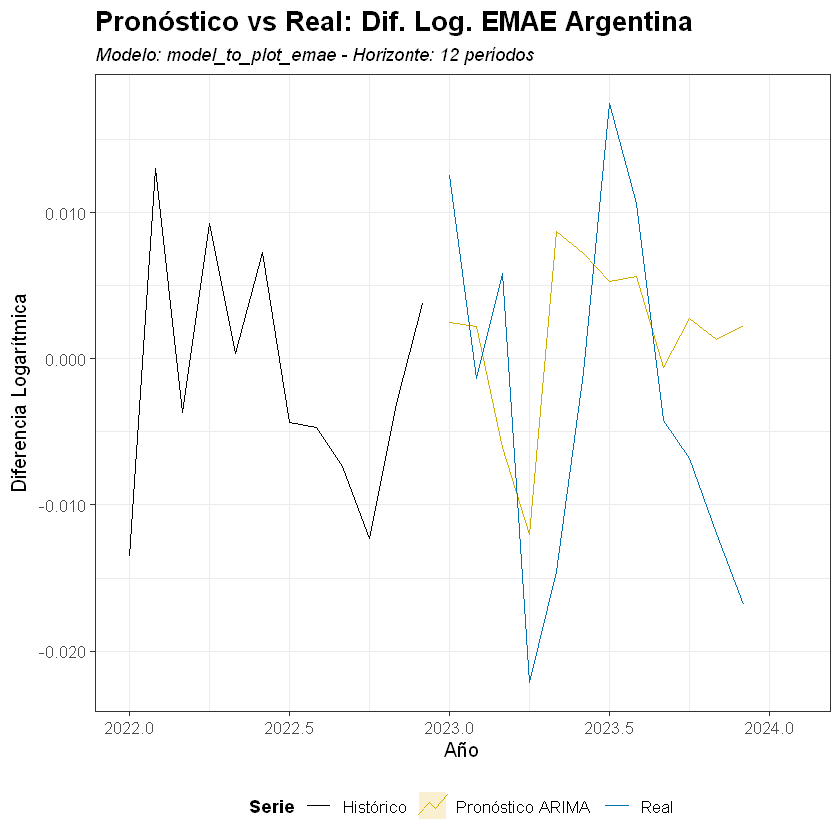

In [152]:
# 4.0 Pronósticos
## 4.1: Proyección del EMAE, Argentina

# a) Definir parámetros del gráfico
h_forecast_emae <- 12
model_to_plot_emae <- model_emae_arg
original_ts_emae <- dl_emae
title_emae <- "Dif. Log. EMAE Argentina"
start_plot_emae <- 2022
ylabel_emae <- "Diferencia Logarítmica"

# b) Llamar a la función para generar el objeto ggplot
# (Asegúrate que la función plot_forecast_vs_actual esté definida/cargada previamente)
plot_emae_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_emae,
  original_ts = original_ts_emae,
  h = h_forecast_emae,
  series_title = title_emae,
  start_year_plot = start_plot_emae,
  ylab_text = ylabel_emae,
  show_pi = FALSE
)

# c) Mostrar el gráfico generado (usando el método implícito de R, como en el script)
plot_emae_comparison

### 4.2 Proyeccion IPC - Argentina

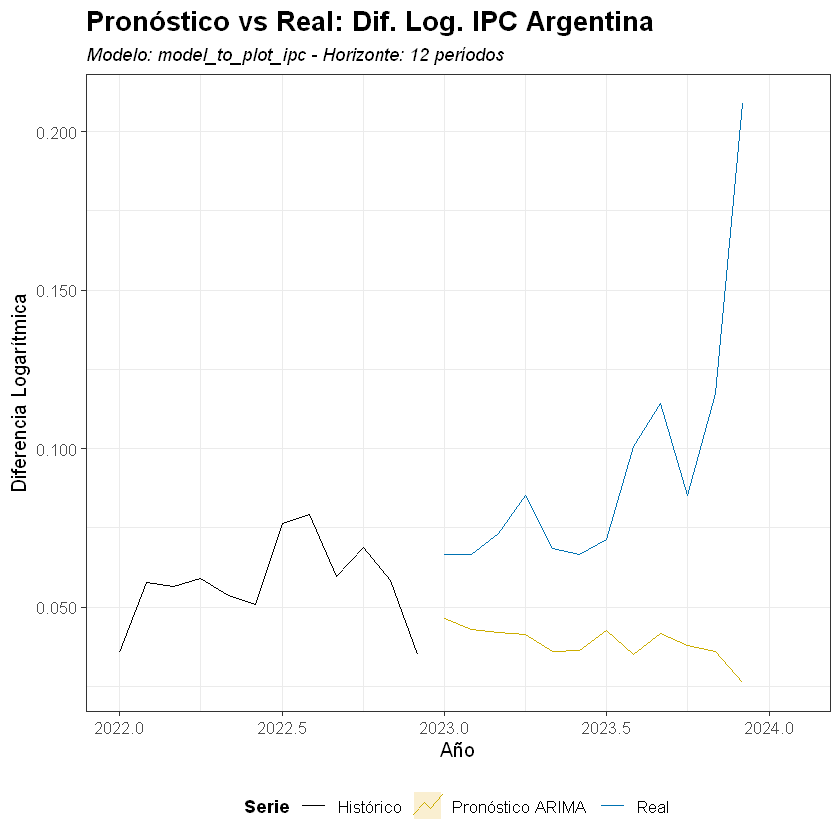

In [153]:
h_forecast_ipc <- 12 # Horizonte
model_to_plot_ipc <- model_ipc_arg # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_ipc <- dl_ipc_arg # Serie original completa (diferencias log)
title_ipc <- "Dif. Log. IPC Argentina" # Título para el gráfico
start_plot_ipc <- 2022 # Año desde donde mostrar histórico
ylabel_ipc <- "Diferencia Logarítmica" # Etiqueta eje Y

plot_ipc_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc,
  original_ts = original_ts_ipc,
  h = h_forecast_ipc,
  series_title = title_ipc,
  start_year_plot = start_plot_ipc,
  ylab_text = ylabel_ipc,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_ipc_comparison


### 4.3 Proyeccion Agregado Monetario M2 - Argentina

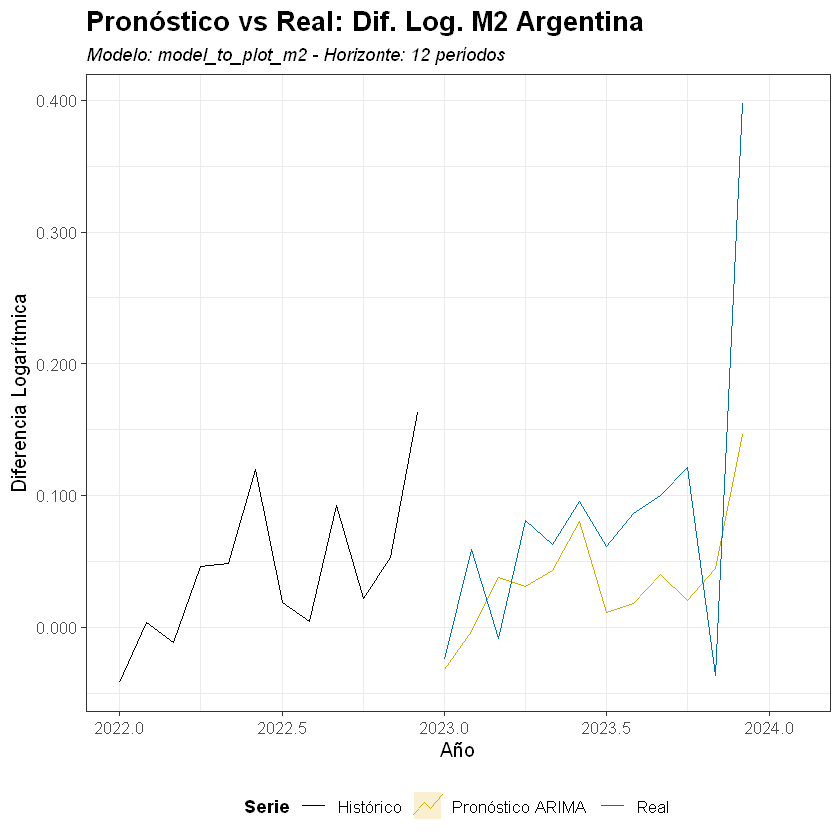

In [154]:
# 2. Definir parámetros específicos para el gráfico del M2
h_forecast_m2 <- 12 # Horizonte
model_to_plot_m2 <- model_m2_arg # Modelo ARIMA ajustado
original_ts_m2 <- dl_m2_arg # Serie original completa (diferencias log)
title_m2 <- "Dif. Log. M2 Argentina" # Título para el gráfico
start_plot_m2 <- 2022 # Año desde donde mostrar histórico
ylabel_m2 <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2,
  original_ts = original_ts_m2,
  h = h_forecast_m2,
  series_title = title_m2,
  start_year_plot = start_plot_m2,
  ylab_text = ylabel_m2,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_m2_comparison


### 4.4 Proyeccion Tasa de interes - Argentina

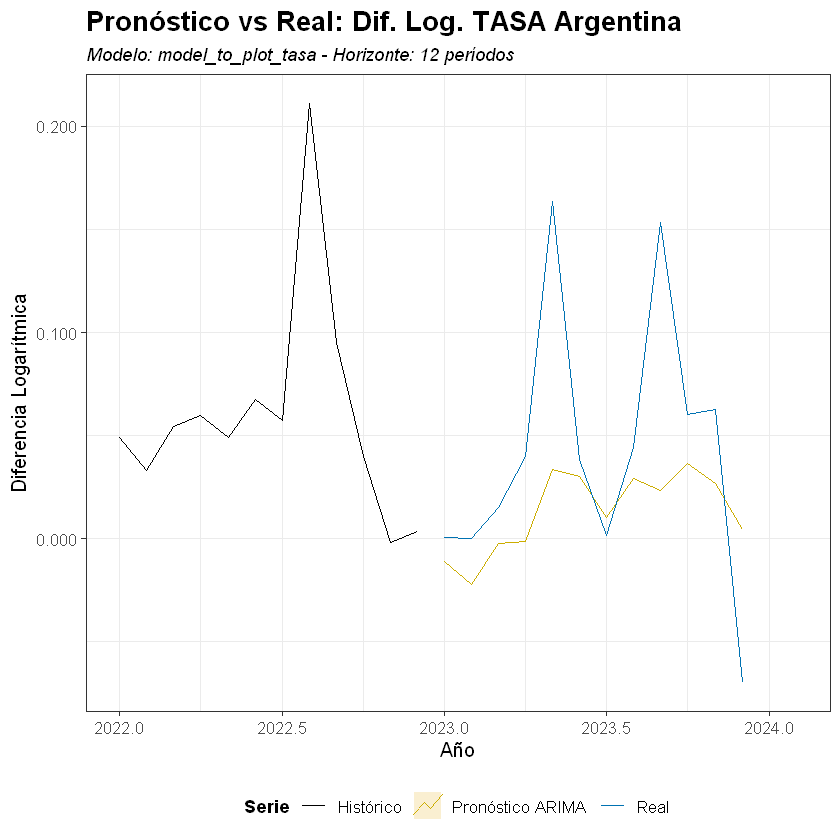

In [155]:
h_forecast_tasa <- 12 # Horizonte
model_to_plot_tasa <- model_tasa_arg # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa <- dl_tasa_arg # Serie original completa (diferencias log)
title_tasa <- "Dif. Log. TASA Argentina" # Título para el gráfico
start_plot_tasa <- 2022 # Año desde donde mostrar histórico
ylabel_tasa <- "Diferencia Logarítmica" # Etiqueta eje Y

plot_tasa_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa,
  original_ts = original_ts_tasa,
  h = h_forecast_tasa,
  series_title = title_tasa,
  start_year_plot = start_plot_tasa,
  ylab_text = ylabel_tasa,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_tasa_comparison

## Chile

### 4.5 Proyeccion IMACEC - Chile

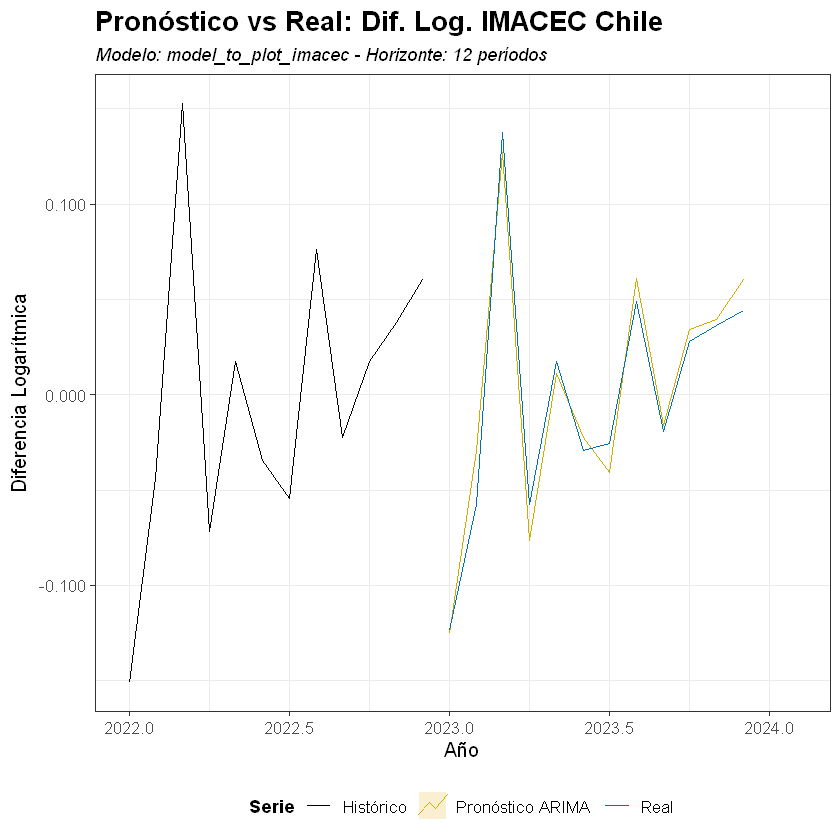

In [156]:
# Modelo ARIMA simplificado sin regresores externos
h_forecast_imacec <- 12
model_to_plot_imacec <- model_imacec_chi
original_ts_imacec <- dl_imacec
title_imacec <- "Dif. Log. IMACEC Chile"
start_plot_imacec <- 2022
ylabel_imacec <- "Diferencia Logarítmica"

# Utilizar la función modular directamente sin complicaciones
plot_imacec_comparison <- plot_forecast_vs_actual(
  model           = model_to_plot_imacec,
  original_ts     = original_ts_imacec,
  h               = h_forecast_imacec,
  series_title    = title_imacec,
  start_year_plot = start_plot_imacec,
  ylab_text       = ylabel_imacec,
  show_pi         = FALSE
)

# Mostrar el gráfico
plot_imacec_comparison


### 4.6 Proyeccion IPC - Chile

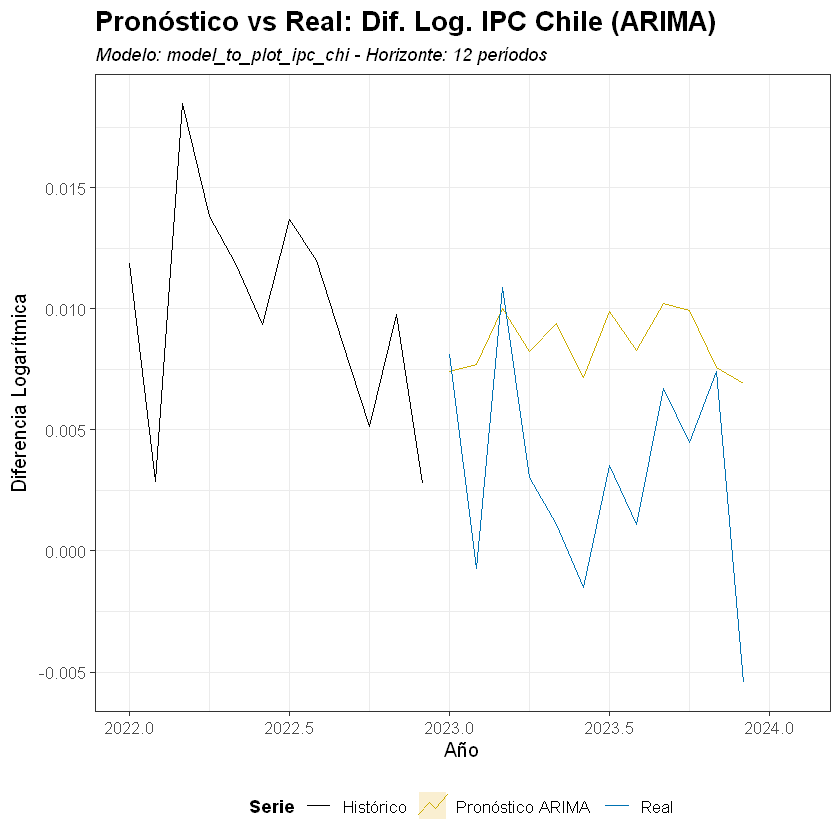

In [157]:
# --- Graficar Pronóstico IPC Chile con modelo ARIMA vs Real usando función modular ---

# 2. Definir parámetros para el gráfico del IPC Chile
h_forecast_ipc_chi <- 12                      # Horizonte
model_to_plot_ipc_chi <- model_ipc_chi        # Usar el nuevo modelo ARIMA
original_ts_ipc_chi <- dl_ipc_chi             # Serie original completa (diferencias log)
title_ipc_chi <- "Dif. Log. IPC Chile (ARIMA)"  # Actualizar título
start_plot_ipc_chi <- 2022                    # Año desde donde mostrar histórico
ylabel_ipc_chi <- "Diferencia Logarítmica"    # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# No necesitamos xreg ya que el nuevo modelo no usa regresores externos
plot_ipc_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_ipc_chi,
  original_ts = original_ts_ipc_chi,
  h = h_forecast_ipc_chi,
  series_title = title_ipc_chi,
  start_year_plot = start_plot_ipc_chi,
  ylab_text = ylabel_ipc_chi,
  show_pi = FALSE  # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_ipc_chi_comparison

### 4.6 Proyeccion Agregado Monetario M2 - Chile

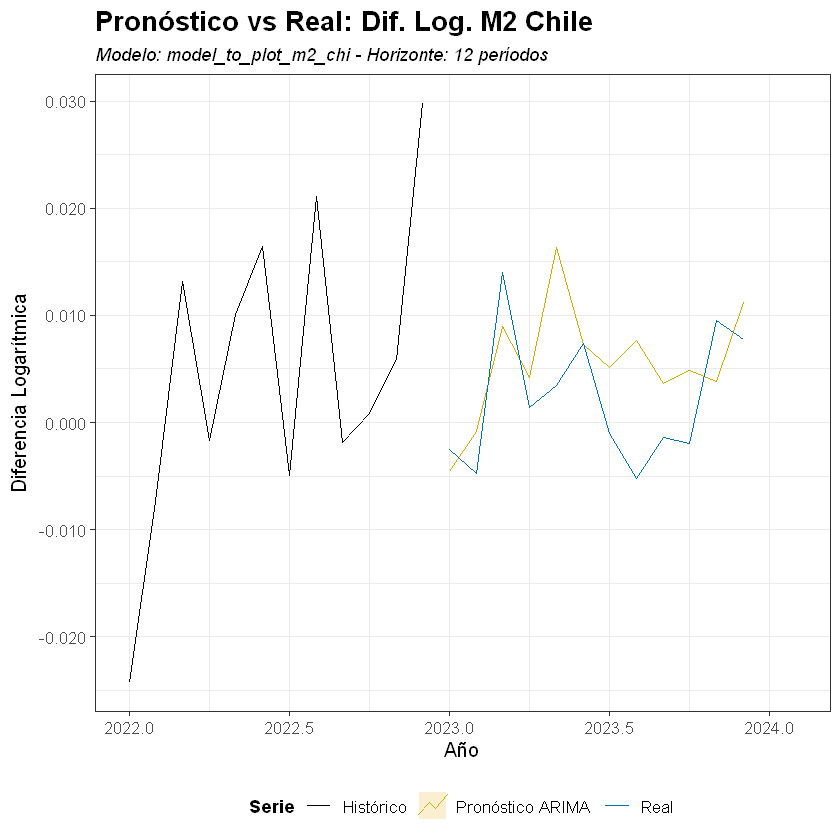

In [158]:
# --- Graficar Pronóstico M2 Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico del M2 Chile
h_forecast_m2_chi <- 12 # Horizonte (asumido)
model_to_plot_m2_chi <- model_m2_chi # Modelo ARIMA ajustado
original_ts_m2_chi <- dl_m2_chi # Serie original completa (diferencias log)
title_m2_chi <- "Dif. Log. M2 Chile" # Título para el gráfico
start_plot_m2_chi <- 2022 # Año desde donde mostrar histórico
ylabel_m2_chi <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
plot_m2_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_m2_chi,
  original_ts = original_ts_m2_chi,
  h = h_forecast_m2_chi,
  series_title = title_m2_chi,
  start_year_plot = start_plot_m2_chi,
  ylab_text = ylabel_m2_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_m2_chi_comparison



### 4.7 Proyeccion Diferencia Logaritmica de Tasa de Interes - Chile

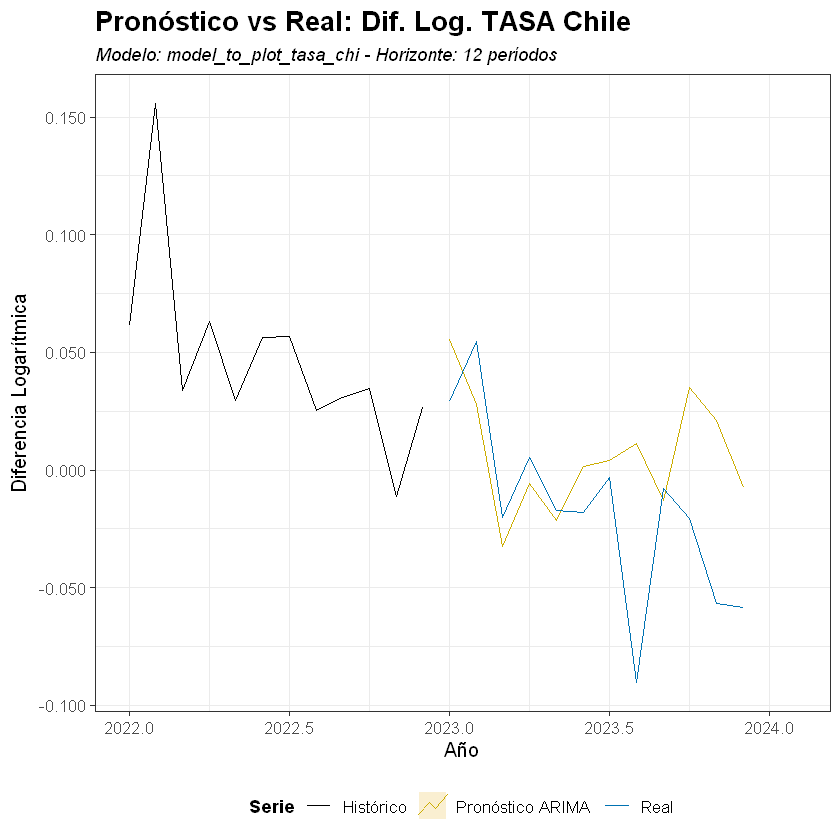

In [159]:
# --- Graficar Pronóstico TASA Chile vs Real usando función modular ---

# 1. Cargar la función desde el script R (si no se ha hecho antes)
# source("plot_forecast_comparison.R")

# 2. Definir parámetros específicos para el gráfico de la TASA Chile
h_forecast_tasa_chi <- 12 # Horizonte
model_to_plot_tasa_chi <- model_tasa_chi # Modelo ARIMA ajustado (forzado o auto.arima)
original_ts_tasa_chi <- dl_tasa_chi # Serie original completa (diferencias log)
title_tasa_chi <- "Dif. Log. TASA Chile" # Título para el gráfico
start_plot_tasa_chi <- 2022 # Año desde donde mostrar histórico
ylabel_tasa_chi <- "Diferencia Logarítmica" # Etiqueta eje Y

# 3. Llamar a la función para generar el objeto ggplot
# Se usa el modelo actual 'model_tasa_chi'. No se pasa xreg.
plot_tasa_chi_comparison <- plot_forecast_vs_actual(
  model = model_to_plot_tasa_chi,
  original_ts = original_ts_tasa_chi,
  h = h_forecast_tasa_chi,
  series_title = title_tasa_chi,
  start_year_plot = start_plot_tasa_chi,
  ylab_text = ylabel_tasa_chi,
  show_pi = FALSE # No mostrar Intervalos de Predicción
)

# 4. Mostrar el gráfico generado
plot_tasa_chi_comparison



# 5 - Comparacion y evaluacion de proyecciones

In [160]:
# --- Retransformación con corrección de Jensen (con manejo de longitudes) ---
retransform_diflog <- function(fc, last_level) {
  # Convertir a valor escalar (número)
  last_log_value <- as.numeric(log(last_level))
  cum_log <- cumsum(fc$mean)

  # Crear vector de resultados
  h <- length(cum_log)
  forecast_levels <- numeric(h)

  # Cálculo manual para cada horizonte
  for (i in 1:h) {
    # Con o sin corrección de Jensen según disponibilidad
    if (!is.null(fc$se) && is.numeric(fc$se)) {
      sigma2 <- (fc$se[i])^2
      forecast_levels[i] <- exp(last_log_value + cum_log[i] + 0.5 * sigma2)
    } else {
      # Sin corrección de Jensen
      forecast_levels[i] <- exp(last_log_value + cum_log[i])
    }
  }

  # Convertir a objeto ts con la misma frecuencia y fecha de inicio que el pronóstico
  start_fc <- start(fc$mean)
  freq_fc <- frequency(fc$mean)
  return(ts(forecast_levels, start = start_fc, frequency = freq_fc))
}


## 5.1 Comparacion y evaluacion de modelos argentinos

In [161]:
# --- Evaluación de Pronósticos ARGENTINA en Niveles (2023) ---

# 2. Definir horizonte y período de evaluación (común)
h_eval <- 12
start_eval <- c(2023, 1)
end_eval <- c(2023, 12)

# 3. Lista para almacenar los resultados de evaluación de Argentina
results_list_arg <- list()

# --- Procesamiento y Evaluación Series ARGENTINAS ---

# Configuración solo para Argentina
series_config_arg <- list(
  list(name = "EMAE Arg", model = model_emae_arg, original_ts = ts_emae, xreg = NULL),
  list(name = "IPC Arg", model = model_ipc_arg, original_ts = ts_ipc_arg, xreg = NULL),
  list(name = "M2 Arg", model = model_m2_arg, original_ts = ts_m2_arg, xreg = NULL),
  list(name = "TASA Arg", model = model_tasa_arg, original_ts = ts_tasa_arg, xreg = NULL)
)

# Bucle para series argentinas
for (cfg in series_config_arg) {
  cat("Procesando ARG:", cfg$name, "\n")

  # Generar pronóstico de diferencias logarítmicas
  fc_diflog <- tryCatch(
    {
      forecast(cfg$model, h = h_eval) # No se necesita xreg para Arg
    },
    error = function(e) {
      warning(paste("Error al pronosticar para", cfg$name, ":", e$message))
      return(NULL)
    }
  )
  if (is.null(fc_diflog)) next

  # Obtener último valor observado de 2022 para retransformación
  last_obs_2022 <- tail(window(cfg$original_ts, end = c(2022, 12)), 1)

  # Retransformar a niveles usando la función común
  fc_levels <- retransform_diflog(fc_diflog, last_obs_2022)

  # Obtener valores reales en niveles
  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)

  # Preparar vectores y validar longitudes
  Y_P <- as.vector(fc_levels)
  Y_A <- as.vector(actual_levels)
  if (length(Y_A) == 0) {
    warning(paste("No hay datos reales para", cfg$name))
    next
  }
  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) {
    warning(paste("Datos incompletos en", cfg$name))
  }
  Y_P <- Y_P[1:min_len]
  Y_A <- Y_A[1:min_len]

  # Evaluar
  evaluation_metrics <- tryCatch(
    {
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
    },
    error = function(e) {
      warning(paste("Error en Eval_Pron para", cfg$name, ":", e$message))
      return(NULL)
    }
  )
  if (is.null(evaluation_metrics)) next

  results_list_arg[[cfg$name]] <- evaluation_metrics
  cat("Evaluación ARG completada para:", cfg$name, "\n\n")
}

# Consolidar y mostrar resultados de Argentina
if (length(results_list_arg) > 0) {
  final_results_table_arg <- do.call(cbind, results_list_arg)
  print("--- Tabla Evaluación ARGENTINA (Niveles 2023) ---")
  print(round(final_results_table_arg, 4))
} else {
  print("No se generaron resultados para Argentina.")
}


Procesando ARG: EMAE Arg 
Evaluación ARG completada para: EMAE Arg 

Procesando ARG: IPC Arg 
Evaluación ARG completada para: IPC Arg 

Procesando ARG: M2 Arg 
Evaluación ARG completada para: M2 Arg 

Procesando ARG: TASA Arg 
Evaluación ARG completada para: TASA Arg 

[1] "--- Tabla Evaluación ARGENTINA (Niveles 2023) ---"
             EMAE Arg   IPC Arg          M2 Arg TASA Arg
RMSE           3.1958 7873.3844 5732754227.2541  25.8595
MAE            2.5997 5704.4467 3936500541.1410  21.0132
MAPE           1.7793   20.5973         16.5435  18.9541
U_Theil        0.0108    0.1915          0.1608   0.1443
U_sesgo        0.2278    0.5249          0.4715   0.6603
U_varianza     0.0571    0.4533          0.5089   0.3301
U_covarianza   0.7151    0.0218          0.0196   0.0096


## 5.2 Comparacion y evaluacion de modelos chilenos


In [162]:
# -----------------------------------------------------------------
# Evaluación de Pronósticos CHILE en Niveles (2023)
library(forecast)
library(lubridate)

if (!exists("Eval_Pron")) stop("Función Eval_Pron no encontrada.")

results_list_chi <- list()
if (!exists("h_eval")) h_eval <- 12
if (!exists("start_eval")) start_eval <- c(2023, 1)
if (!exists("end_eval")) end_eval <- c(2023, 12)

series_config_chi <- list(
  list(name = "IMACEC Chi", model = model_imacec_chi, original_ts = ts_imacec, needs_xreg_future = FALSE),
  list(name = "IPC Chi", model = model_ipc_chi, original_ts = ts_ipc_chi, needs_xreg_future = TRUE),
  list(name = "M2 Chi", model = model_m2_chi, original_ts = ts_m2_chi, needs_xreg_future = FALSE),
  list(name = "TASA Chi", model = model_tasa_chi, original_ts = ts_tasa_chi, needs_xreg_future = FALSE)
)

for (cfg in series_config_chi) {
  cat("Procesando Evaluación para:", cfg$name, "...\n")
  xreg_future <- NULL
  if (cfg$needs_xreg_future && cfg$name == "IPC Chi") {
    future_ts <- ts(1:h_eval, start = start_eval, frequency = 12)
    future_mes <- factor(cycle(future_ts), levels = 1:12)
    xreg_future <- model.matrix(~future_mes)[, -1]
  }

  fc_diflog <- tryCatch(
    {
      if (cfg$needs_xreg_future) {
        forecast(cfg$model, h = h_eval, xreg = xreg_future)
      } else {
        forecast(cfg$model, h = h_eval)
      }
    },
    error = function(e) {
      warning(e$message)
      return(NULL)
    }
  )
  if (is.null(fc_diflog)) next

  last_obs_2022 <- tail(window(cfg$original_ts, end = c(2022, 12)), 1)
  fc_levels <- retransform_diflog(fc_diflog, last_obs_2022)

  actual_levels <- window(cfg$original_ts, start = start_eval, end = end_eval)
  Y_P <- as.vector(fc_levels)
  Y_A <- as.vector(actual_levels)

  min_len <- min(length(Y_P), length(Y_A))
  if (min_len < h_eval) warning(paste(cfg$name, ": horizonte reducido a", min_len))
  Y_P <- Y_P[1:min_len]
  Y_A <- Y_A[1:min_len]

  eval_metrics <- tryCatch(
    {
      Eval_Pron(Y_P = Y_P, Y_A = Y_A, Nombre = cfg$name)
    },
    error = function(e) {
      warning(e$message)
      return(NULL)
    }
  )
  if (is.null(eval_metrics)) next

  results_list_chi[[cfg$name]] <- eval_metrics
  cat(" -> Evaluación completada.\n")
}

if (length(results_list_chi) > 0) {
  tabla_chi <- do.call(cbind, results_list_chi)
  cat("\n--- Tabla Evaluación CHILE (Niveles 2023) ---\n")
  print(round(tabla_chi, 4))
} else {
  cat("No se generaron resultados de evaluación para Chile.\n")
}


Procesando Evaluación para: IMACEC Chi ...
 -> Evaluación completada.
Procesando Evaluación para: IPC Chi ...


Warning message in forecast.forecast_ARIMA(cfg$model, h = h_eval, xreg = xreg_future):
"xreg not required by this model, ignoring the provided regressors"


 -> Evaluación completada.
Procesando Evaluación para: M2 Chi ...
 -> Evaluación completada.
Procesando Evaluación para: TASA Chi ...
 -> Evaluación completada.

--- Tabla Evaluación CHILE (Niveles 2023) ---
             IMACEC Chi IPC Chi    M2 Chi TASA Chi
RMSE             1.4311  3.7765 4697.1157   1.7707
MAE              1.0686  3.1432 3652.0657   1.1843
MAPE             0.9858  3.1330    2.0335   8.7087
U_Theil          0.0066  0.0186    0.0130   0.0567
U_sesgo          0.0868  0.6879    0.5504   0.3112
U_varianza       0.2070  0.2942    0.3404   0.2945
U_covarianza     0.7061  0.0179    0.1092   0.3943


# 6. Comparación con Suavizado Exponencial (ETS) sin Tendencia

## 6.1 Comparacion ETS Argentina

ETS(A,N,N) 

Call:
forecast::ets(y = dl_emae_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.0001 

  Initial states:
    l = 0.0021 

  sigma:  0.0193

      AIC      AICc       BIC 
-556.0990 -555.9914 -545.8242 

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.0002806893 0.01924357 0.01100706 75.88926 144.4524 0.6467098
                  ACF1
Training set 0.1010451

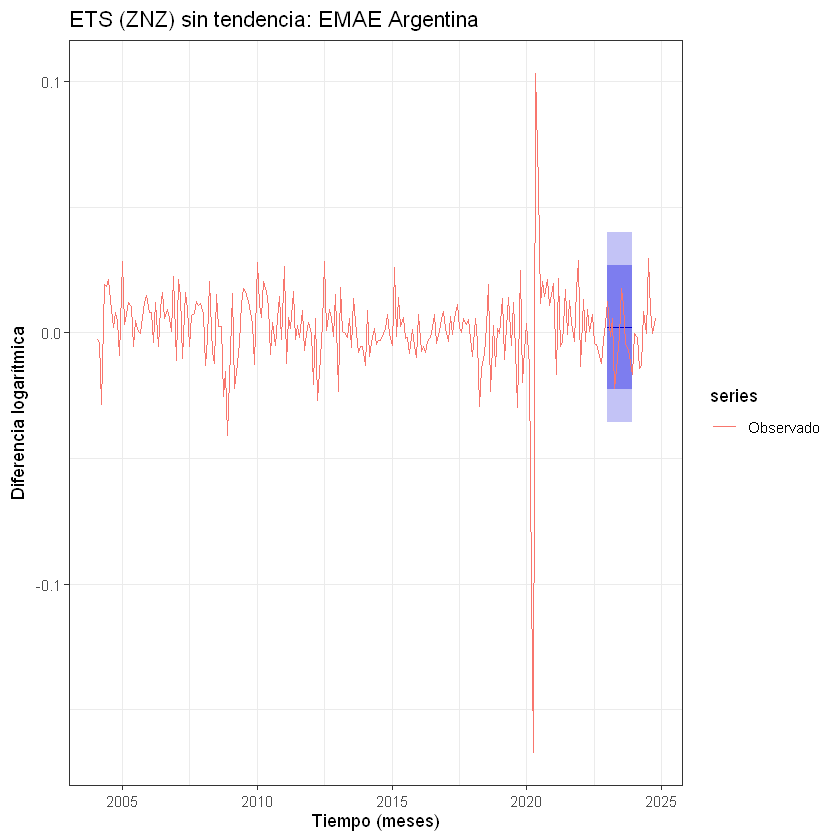

In [163]:
### 5.1 EMAE:####
model_ets_emae <- forecast::ets(dl_emae_train, model = "ZNZ")

# Resumen del modelo ETS
summary(model_ets_emae)

# Pronóstico h=12
forecast_ets_emae <- forecast::forecast(model_ets_emae, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_emae completa)
autoplot(forecast_ets_emae) +
  autolayer(dl_emae, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS (ZNZ) sin tendencia: EMAE Argentina") +
  xlab("Tiempo (meses)") +
  ylab("Diferencia logarítmica") +
  theme_bw()





ETS(A,N,N) 

Call:
forecast::ets(y = dl_ipc_arg_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.4007 

  Initial states:
    l = 0.0019 

  sigma:  0.0116

      AIC      AICc       BIC 
-789.6826 -789.5750 -779.4078 

Training set error measures:
                       ME       RMSE         MAE       MPE     MAPE      MASE
Training set 0.0005509754 0.01150378 0.008307474 -73.34592 134.0151 0.6160606
                     ACF1
Training set -0.003258809

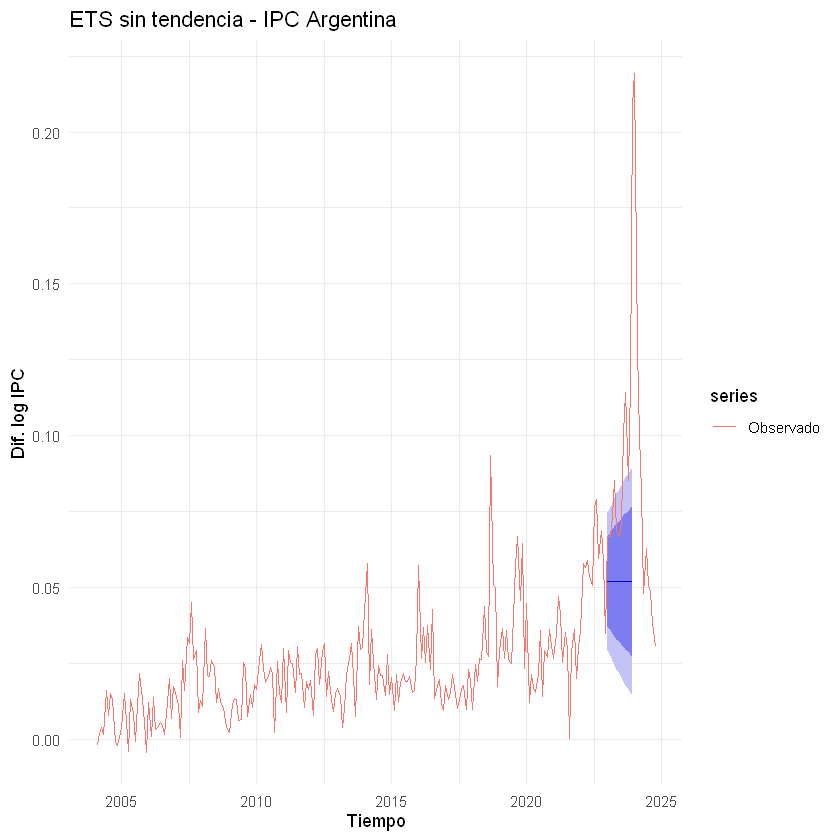

In [164]:
### 5.2 IPC:####
# Estimar modelo ETS (ZNZ)
ets_ipc_arg <- forecast::ets(dl_ipc_arg_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_ipc_arg)

# Pronóstico h=12
forecast_ets_ipc_arg <- forecast::forecast(ets_ipc_arg, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_ipc_arg completa)
autoplot(forecast_ets_ipc_arg) +
  autolayer(dl_ipc_arg, series = "Observado") + # Usa la serie dl_ completa
  # Título y etiquetas como en el script (incluyendo la nota humorística)
  ggtitle("ETS sin tendencia - IPC Argentina") +
  xlab("Tiempo") + ylab("Dif. log IPC") +
  theme_minimal() # Tema como en el script


ETS(A,N,A) 

Call:
forecast::ets(y = dl_m2_arg_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.0415 
    gamma = 0.0001 

  Initial states:
    l = 0.0206 
    s = -0.0676 0.1082 0.0138 -0.0097 -0.007 -0.0099
           -0.0139 0.0367 0.0009 -0.0032 -0.0104 -0.0378

  sigma:  0.0275

      AIC      AICc       BIC 
-383.8463 -381.5714 -332.4721 

Training set error measures:
                      ME       RMSE        MAE       MPE     MAPE     MASE
Training set 0.001839018 0.02667494 0.01908746 -30.15407 146.7653 0.792331
                   ACF1
Training set -0.1084151

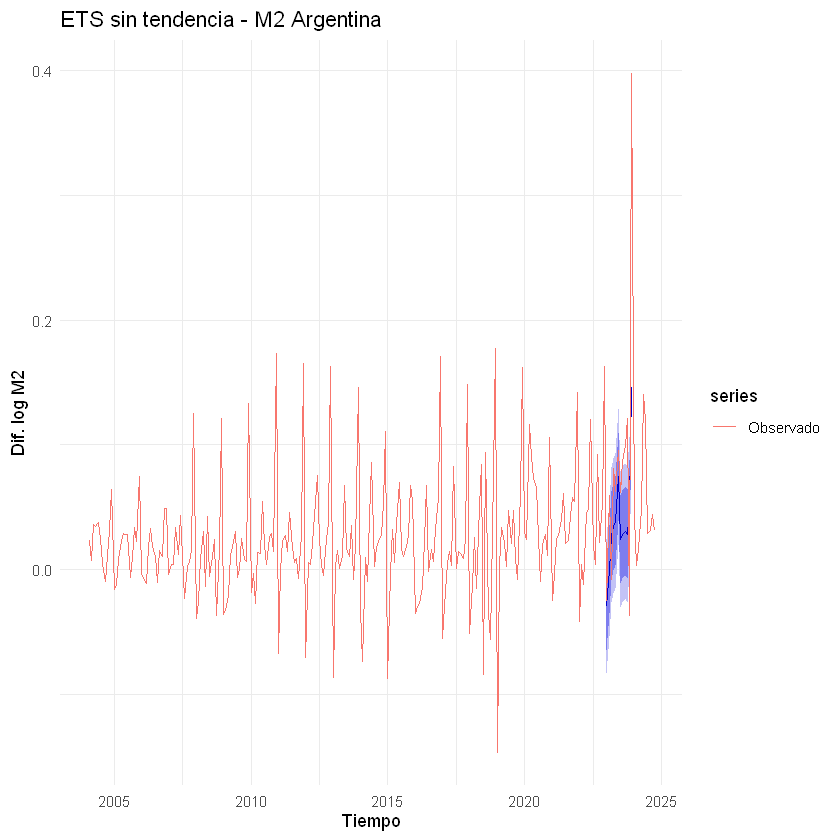

In [165]:
### 5.3 M2:####
# Estimar modelo ETS (ZNZ)
ets_m2_arg <- forecast::ets(dl_m2_arg_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_m2_arg)

# Pronóstico h=12
forecast_ets_m2_arg <- forecast::forecast(ets_m2_arg, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_m2_arg completa)
autoplot(forecast_ets_m2_arg) +
  autolayer(dl_m2_arg, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - M2 Argentina") +
  xlab("Tiempo") + ylab("Dif. log M2") +
  theme_minimal() # Tema como en el script


ETS(A,N,N) 

Call:
forecast::ets(y = dl_tasa_arg_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.4246 

  Initial states:
    l = -0.0796 

  sigma:  0.0614

      AIC      AICc       BIC 
-31.27099 -31.16336 -20.99614 

Training set error measures:
                      ME       RMSE        MAE MPE MAPE     MASE      ACF1
Training set 0.001115376 0.06114118 0.03940408 NaN  Inf 0.612391 0.2442115

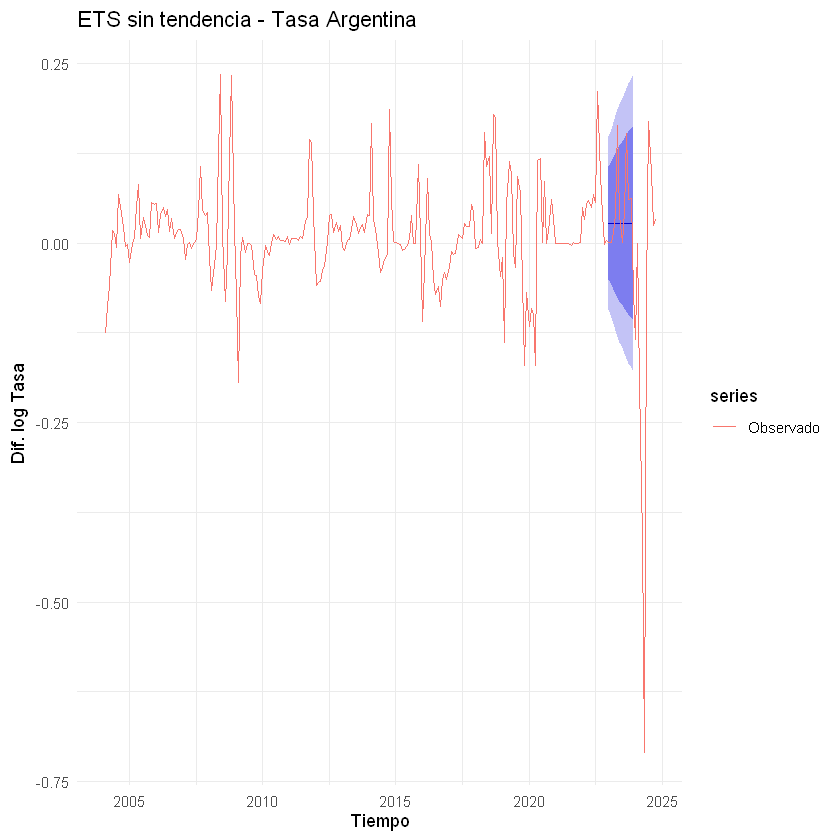

In [166]:
### 5.4 Tasa de interés:####
# Estimar modelo ETS (ZNZ)
ets_tasa_arg <- forecast::ets(dl_tasa_arg_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_tasa_arg)

# Pronóstico h=12
forecast_ets_tasa_arg <- forecast::forecast(ets_tasa_arg, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_tasa_arg completa)
autoplot(forecast_ets_tasa_arg) +
  autolayer(dl_tasa_arg, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - Tasa Argentina") +
  xlab("Tiempo") + ylab("Dif. log Tasa") +
  theme_minimal() # Tema como en el script

## 6.1 Comparacion ETS Chile

ETS(A,N,A) 

Call:
forecast::ets(y = dl_imacec_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.0002 
    gamma = 0.2988 

  Initial states:
    l = 0.0044 
    s = -0.0945 0.0457 0.0068 0.0705 -0.0253 0.0228
           -0.0302 -0.0241 -0.0142 -0.0247 0.1104 -0.0432

  sigma:  0.0178

      AIC      AICc       BIC 
-580.8238 -578.5490 -529.4496 

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.0004625347 0.01728525 0.01152521 -12.25128 63.97938 0.8114877
                  ACF1
Training set -0.017733

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


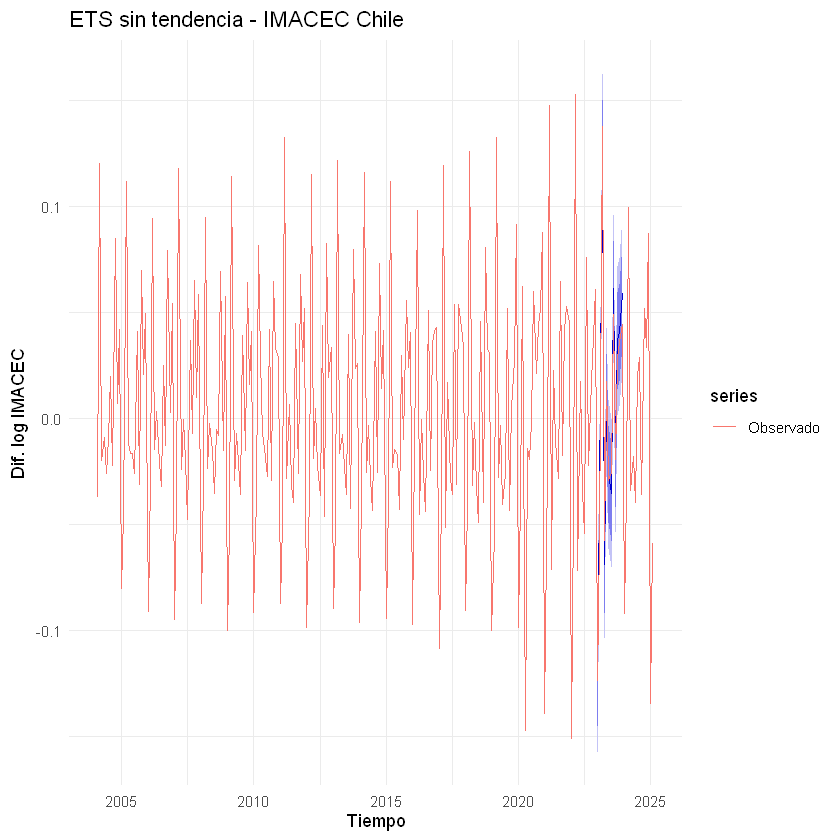

In [167]:
### 5.5 IMACEC:####
# Estimar modelo ETS (ZNZ)
ets_imacec <- forecast::ets(dl_imacec_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_imacec)

# Pronóstico h=12
forecast_ets_imacec <- forecast::forecast(ets_imacec, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_imacec completa)
autoplot(forecast_ets_imacec) +
  autolayer(dl_imacec, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - IMACEC Chile") +
  xlab("Tiempo") + ylab("Dif. log IMACEC") +
  theme_minimal() # Tema como en el script

ETS(A,N,A) 

Call:
forecast::ets(y = dl_ipc_chi_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.2711 
    gamma = 0.0792 

  Initial states:
    l = 0.0009 
    s = -0.0017 -0.0032 -0.0015 0.0011 0.0032 0.0001
           0.0011 0.0006 -0.0004 0.0008 0.0022 -0.0024

  sigma:  0.0036

      AIC      AICc       BIC 
-1312.014 -1309.739 -1260.640 

Training set error measures:
                       ME        RMSE         MAE MPE MAPE      MASE     ACF1
Training set 0.0001134822 0.003453201 0.002619865 NaN  Inf 0.6926031 0.196613

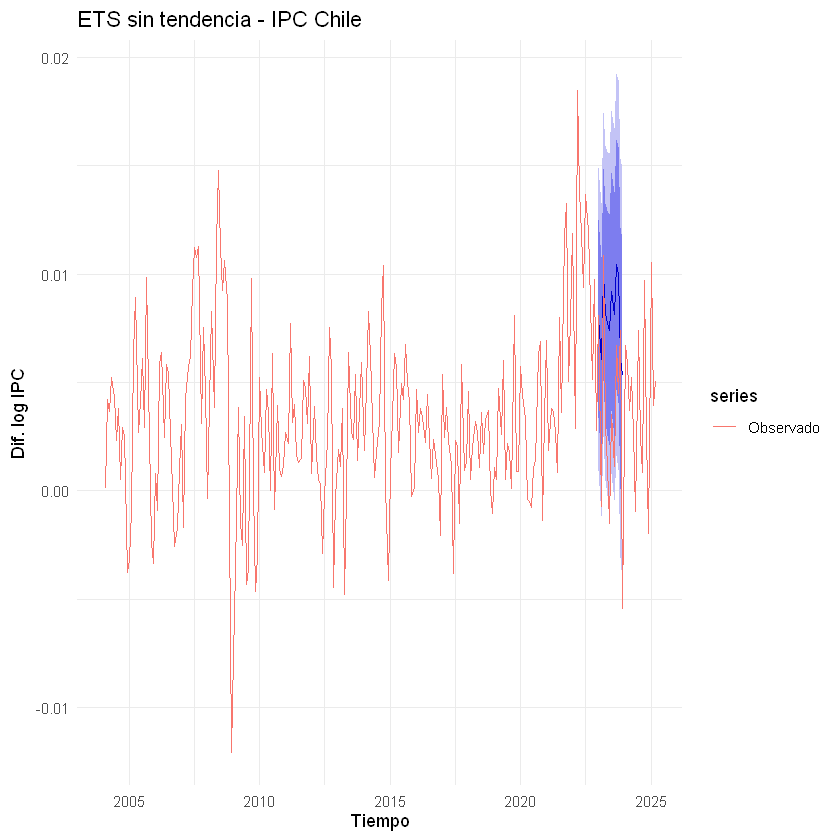

In [168]:
### 5.6 IPC####
# Estimar modelo ETS (ZNZ)
ets_ipc_chi <- forecast::ets(dl_ipc_chi_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_ipc_chi)

# Pronóstico h=12
forecast_ets_ipc_chi <- forecast::forecast(ets_ipc_chi, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_ipc_chi completa)
autoplot(forecast_ets_ipc_chi) +
  autolayer(dl_ipc_chi, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - IPC Chile") +
  xlab("Tiempo") + ylab("Dif. log IPC") +
  theme_minimal() # Tema como en el script


ETS(A,N,A) 

Call:
forecast::ets(y = dl_m2_chi_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.034 
    gamma = 0.0001 

  Initial states:
    l = 0.0141 
    s = -0.0121 0.0184 0.002 0.0004 -0.0023 0.0014
           -0.0034 -0.0067 0.0036 0.0004 0.0066 -0.0083

  sigma:  0.0124

      AIC      AICc       BIC 
-745.7924 -743.5175 -694.4181 

Training set error measures:
                       ME       RMSE         MAE       MPE    MAPE      MASE
Training set -0.001154268 0.01201897 0.009386236 -22.15759 255.208 0.7586171
                    ACF1
Training set -0.03738409

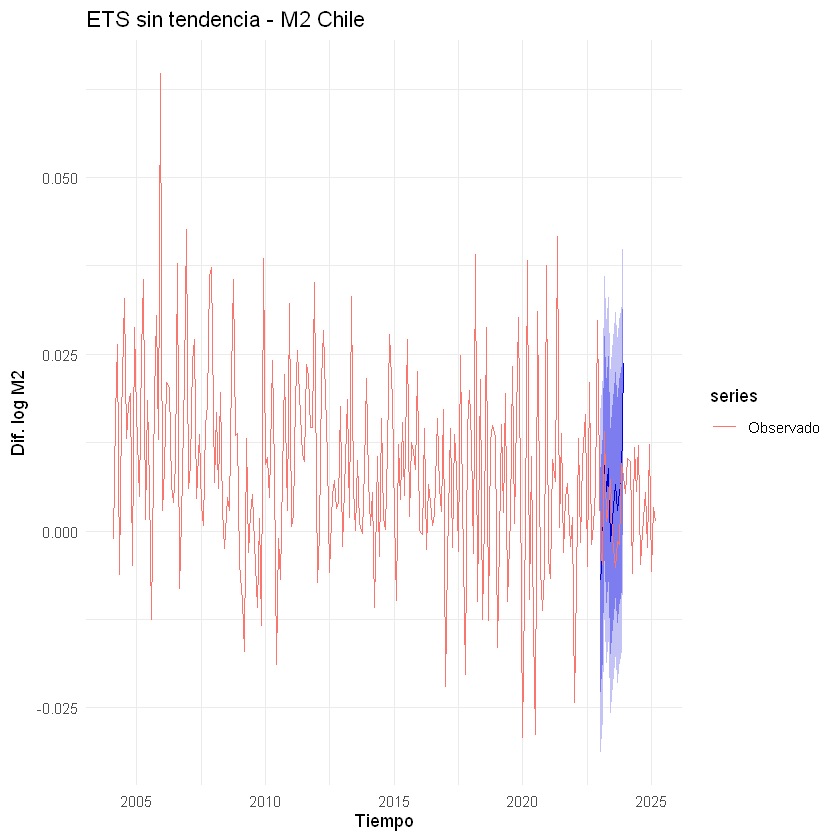

In [169]:
### 5.7 M2####
# Estimar modelo ETS (ZNZ)
ets_m2_chi <- forecast::ets(dl_m2_chi_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_m2_chi)

# Pronóstico h=12
forecast_ets_m2_chi <- forecast::forecast(ets_m2_chi, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_m2_chi completa)
autoplot(forecast_ets_m2_chi) +
  autolayer(dl_m2_chi, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - M2 Chile") +
  xlab("Tiempo") + ylab("Dif. log M2") +
  theme_minimal() # Tema como en el script


ETS(A,N,A) 

Call:
forecast::ets(y = dl_tasa_chi_train, model = "ZNZ")

  Smoothing parameters:
    alpha = 0.0603 
    gamma = 0.0001 

  Initial states:
    l = 0.0045 
    s = 0.0495 -0.013 0.0136 0.0273 -0.0166 -0.0002
           0.0014 -0.0062 -0.0244 -0.0133 -0.0378 0.0197

  sigma:  0.0655

     AIC     AICc      BIC 
 9.41978 11.69466 60.79403 

Training set error measures:
                      ME       RMSE        MAE     MPE     MAPE      MASE
Training set 0.002199667 0.06343079 0.04466912 101.009 210.0549 0.6984122
                   ACF1
Training set 0.03488219

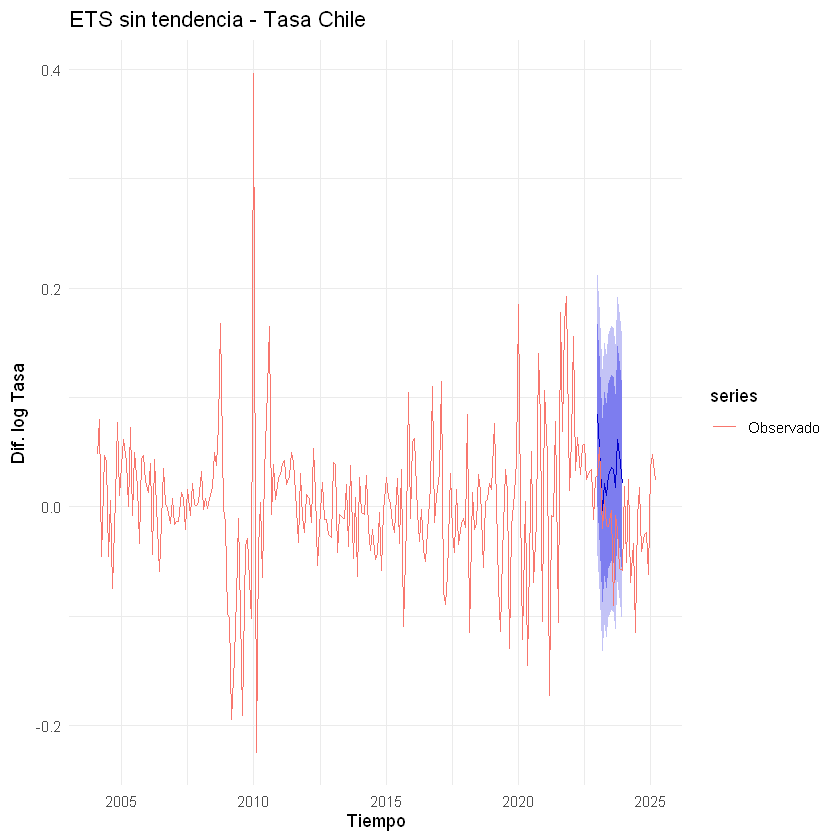

In [170]:
### 5.8 Tasa de interés####
# Estimar modelo ETS (ZNZ)
ets_tasa_chi <- forecast::ets(dl_tasa_chi_train, model = "ZNZ") # Variable renombrada como en script

# Resumen
summary(ets_tasa_chi)

# Pronóstico h=12
forecast_ets_tasa_chi <- forecast::forecast(ets_tasa_chi, h = 12)

# Gráfico: Pronóstico ETS vs Serie Observada (dl_tasa_chi completa)
autoplot(forecast_ets_tasa_chi) +
  autolayer(dl_tasa_chi, series = "Observado") + # Usa la serie dl_ completa
  ggtitle("ETS sin tendencia - Tasa Chile") +
  xlab("Tiempo") + ylab("Dif. log Tasa") +
  theme_minimal() # Tema como en el script